# DS4440 - Practical Neural Networks
## Understanding Transformers & Tokenization 

___
**Instructor** : Prof. Steve Schmidt <br/>
**Teaching Assistants** : Vishwajeet Hogale (hogale.v@northeastern.edu) | Chaitanya Agarwal (agarwal.cha@northeastern.edu)

## Problem Statement  
In this notebook, we'll explore **Transformers** using a popular NLP dataset. Transformers are a class of deep learning models designed to understand and generate natural language by learning the underlying contextual relationships in text.

### We will:  
- Build a **Transformer-based model** to generate synthetic text  
- Understand how **Self-Attention** and **Positional Encoding** work together in an encoder-decoder setup (or a decoder-only setup for language modeling)  
- Explore how Transformers can be used for **text generation**, **translation**, and **summarization**  

### What makes Transformers special?  
- They employ **Self-Attention Mechanisms** to capture dependencies across all positions in the input sequence  
- They enable **parallel processing** of tokens, leading to more efficient training compared to traditional sequential models  
- They have become the foundation for state-of-the-art models such as **BERT, GPT, and T5**  
- Transformers are versatile and have revolutionized tasks in **language understanding, text synthesis, and beyond**


## 0. Setup and Load libraries

The below cell helps you download all the necessary libraries or packages required to run this notebook without running into any errors.

In [1]:
! pip install -r requirements.txt

## 1. Data Gathering

## WikiText-2 Dataset Overview

WikiText-2 is a widely used benchmark dataset for language modeling and text generation tasks. It is curated from Wikipedia articles, providing a rich source of natural language data that is ideal for training and evaluating NLP models.

### Dataset Details

- **Source:** Extracted from Wikipedia articles
- **Content:** Long-form natural language text
- **Token Count:** Approximately 2 million tokens
- **Splits:** 
  - **Training Set:** Main portion of the data for training language models
  - **Validation Set:** Used for hyperparameter tuning and model selection
  - **Test Set:** Reserved for evaluating the final model performance

### Applications

WikiText-2 is particularly suited for:
- **Language Modeling:** Training models to predict the next word in a sequence.
- **Text Generation:** Generating coherent and contextually relevant text.
- **Transfer Learning:** Fine-tuning pre-trained models for specialized tasks.
- **Benchmarking:** Comparing the performance of various language modeling techniques.

### Advantages of Using WikiText-2

- **Rich Linguistic Content:** Maintains detailed natural language structure and a diverse vocabulary.
- **Real-World Data:** The dataset reflects authentic written language, making it valuable for developing robust models.
- **Community Standard:** Widely adopted in the NLP community, facilitating reproducibility and comparison across research works.

### Accessing WikiText-2

The dataset is easily accessible through popular libraries such as Hugging Face's `datasets`. This allows you to quickly download, preprocess, and integrate it into your NLP projects.




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from transformers import AutoTokenizer
import random
from tqdm import tqdm


### Load the Dataset
We use the WikiText‑2 raw dataset (small enough to run on a laptop). We first concatenate the text (skipping empty lines)

In [3]:
# Load the WikiText-2 dataset (still using the full dataset object)
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Modify the function to take only a subset (e.g., first 100 lines)
def concatenate_text(split, num_lines=100):
    # Filter non-empty lines and take only the first num_lines entries
    lines = [line for line in split["text"] if line.strip() != ""]
    return " ".join(lines[:num_lines])

# Use a much smaller subset of the training data
train_text = concatenate_text(dataset["train"], num_lines=200)


In [4]:
train_text

' = Valkyria Chronicles III = \n  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n  The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series

Clean up the data a little bit

In [5]:
import re

# Split the training text into words
words = train_text.split()

# Remove any non-ASCII characters from each word
clean_words = [re.sub(r'[^\x00-\x7F]', '', word) for word in words]

# Recombine the cleaned words into a single text string
clean_train_text = " ".join(clean_words)
print(clean_train_text)

= Valkyria Chronicles III = Senj no Valkyria 3 : Unrecorded Chronicles ( Japanese : 3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Characte

### If I were to just use a whitspace to generate tokens 

In [6]:
clean_train_text.split()

['=',
 'Valkyria',
 'Chronicles',
 'III',
 '=',
 'Senj',
 'no',
 'Valkyria',
 '3',
 ':',
 'Unrecorded',
 'Chronicles',
 '(',
 'Japanese',
 ':',
 '3',
 ',',
 'lit',
 '.',
 'Valkyria',
 'of',
 'the',
 'Battlefield',
 '3',
 ')',
 ',',
 'commonly',
 'referred',
 'to',
 'as',
 'Valkyria',
 'Chronicles',
 'III',
 'outside',
 'Japan',
 ',',
 'is',
 'a',
 'tactical',
 'role',
 '@-@',
 'playing',
 'video',
 'game',
 'developed',
 'by',
 'Sega',
 'and',
 'Media.Vision',
 'for',
 'the',
 'PlayStation',
 'Portable',
 '.',
 'Released',
 'in',
 'January',
 '2011',
 'in',
 'Japan',
 ',',
 'it',
 'is',
 'the',
 'third',
 'game',
 'in',
 'the',
 'Valkyria',
 'series',
 '.',
 'Employing',
 'the',
 'same',
 'fusion',
 'of',
 'tactical',
 'and',
 'real',
 '@-@',
 'time',
 'gameplay',
 'as',
 'its',
 'predecessors',
 ',',
 'the',
 'story',
 'runs',
 'parallel',
 'to',
 'the',
 'first',
 'game',
 'and',
 'follows',
 'the',
 '"',
 'Nameless',
 '"',
 ',',
 'a',
 'penal',
 'military',
 'unit',
 'serving',
 'th

#### Corpus size

In [7]:
len(clean_train_text.split())

10705

## Tokenizers: A Simple Overview

Tokenizers are essential tools in natural language processing (NLP) that convert raw text into a format that models can understand. They break down text into smaller units called *tokens*—which can be words, subwords, or even individual characters—and then map these tokens to unique numerical identifiers (token IDs).

### The tokenizations that we will discuss in this notebook are as follows : 
1. **Byte-Pair Encoding** : 
Byte-Pair Encoding (BPE) is a popular subword tokenization algorithm. Rather than treating words as the smallest unit, BPE iteratively merges the most frequent pairs of characters (or bytes) to build a vocabulary of subword units. This enables the model to balance between character‐level (which has no out‑of‑vocabulary issues) and word‑level tokenization (which captures semantic units).
2. **Vision Tokenization** : 
In vision applications—such as those using Vision Transformers (ViT)—images are “tokenized” by splitting them into fixed‑size patches. Each patch is then flattened and linearly projected into an embedding vector. These vectors serve as tokens that a transformer model can process similarly to text tokens.
3. **Transformer based tokenization** : 
- **Text Splitting:** They segment sentences into tokens based on rules or learned patterns.
- **Mapping to IDs:** Each token is converted into a number using a vocabulary. This mapping allows models to process text as numerical data.
- **Handling Special Tokens:** Tokenizers often add special tokens (like `[CLS]`, `[SEP]` for Transformers) to indicate the beginning, separation, or end of sequences.
<br/><br/>
In Summary, tokenizers bridge the gap between human language and machine-readable input, enabling complex models to understand and generate text.


### How Models Use Tokenizers

- **Transformers and Other Models:** Models such as Transformers, LSTMs, or even CNNs for NLP require numerical input. Tokenizers provide this by turning text into sequences of token IDs.
- **Embedding Layers:** The token IDs are passed to an embedding layer that transforms them into dense vector representations. These vectors capture semantic information about the tokens.
- **Sequence Processing:** The models then process these sequences to perform tasks like text classification, translation, or generation.
- **Fine-Tuning:** When models are fine-tuned on specific tasks, the tokenized inputs ensure consistency with the pre-training phase, making the learned representations effective for new tasks.




## Byte Pair Encoding
**Byte-Pair Encoding (BPE)** is a simple yet powerful tokenization algorithm that builds a vocabulary of subword units. Here’s how it works in simple terms:



1. **Start at the Character Level:**  
   Initially, every character in the text is considered as an individual token.

2. **Count Pair Frequencies:**  
   Look for the most frequently occurring pair of tokens (initially, individual characters) in the text.

3. **Merge Frequent Pairs:**  
   Merge the most frequent pair into a new token. This new token represents a combination of two characters or previously merged tokens.

4. **Repeat:**  
   The process is repeated—counting pairs and merging the most frequent one—until a predetermined vocabulary size is reached.

5. **Final Vocabulary:**  
   The resulting vocabulary consists of tokens that can be whole words, subwords, or even individual characters. This approach allows the model to efficiently handle rare or unseen words by breaking them down into known subword units.

**Key Advantages:**

- **Handles Unknown Words:** By breaking down words into subwords, BPE can represent words not seen during training.
- **Balances Granularity:** It finds a middle ground between character-level and word-level tokenization, capturing meaningful parts of words.
- **Efficient:** Merging frequent pairs reduces the overall vocabulary size while still retaining important language patterns.


To learn more about BPE tokenization, please watch this youtube video https://www.youtube.com/watch?v=HEikzVL-lZU



In [8]:
# %% [code]
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Initialize a BPE tokenizer with an unknown token
tokenizer_bpe = Tokenizer(models.BPE(unk_token="[UNK]"))

# Use a pre-tokenizer that splits on whitespace
tokenizer_bpe.pre_tokenizer = pre_tokenizers.Whitespace()

# Define a small corpus for demonstration purposes
corpus = clean_train_text.split()

# Set up a BPE trainer with a limited vocabulary size for illustration
trainer = trainers.BpeTrainer(vocab_size=20, special_tokens=["[UNK]"])

# Train the tokenizer on the provided corpus
tokenizer_bpe.train_from_iterator(corpus, trainer=trainer)




    



In [9]:
# Display the resulting vocabulary
print("Vocabulary:", tokenizer_bpe.get_vocab())

Vocabulary: {"'": 4, 'g': 59, 't': 72, '5': 16, ':': 21, 'D': 28, 'b': 54, 'A': 25, 'U': 45, '2': 13, 'B': 26, 'x': 76, 'I': 33, '(': 5, '.': 9, 'k': 63, 'p': 68, 'R': 42, '3': 14, '@': 24, 'u': 73, '1': 12, 'm': 65, 'F': 30, 'K': 35, 'V': 46, 'L': 36, 'H': 32, 'W': 47, '9': 20, 'n': 66, 'z': 78, '/': 10, 'd': 56, '8': 19, 'Z': 50, '7': 18, 'G': 31, 'T': 44, '-': 8, 'C': 27, '$': 2, '[UNK]': 0, ')': 6, '0': 11, 'E': 29, 'J': 34, 'P': 40, 'h': 60, 'y': 77, 'O': 39, 'Y': 49, ',': 7, '6': 17, ';': 22, 'f': 58, 's': 71, 'S': 43, 'N': 38, 'Q': 41, 'o': 67, 'M': 37, 'v': 74, 'c': 55, 'j': 62, '&': 3, '"': 1, 'r': 70, '=': 23, '[': 51, 'w': 75, 'i': 61, '4': 15, 'e': 57, 'X': 48, 'l': 64, ']': 52, 'a': 53, 'q': 69}


In [10]:
# Tokenize each word in the corpus and display the resulting tokens and token IDs
for word in corpus:
    encoding = tokenizer_bpe.encode(word)
    print(f"Word: '{word}'  -->  Tokens: {encoding.tokens}, Token IDs: {encoding.ids}")

Word: '='  -->  Tokens: ['='], Token IDs: [23]
Word: 'Valkyria'  -->  Tokens: ['V', 'a', 'l', 'k', 'y', 'r', 'i', 'a'], Token IDs: [46, 53, 64, 63, 77, 70, 61, 53]
Word: 'Chronicles'  -->  Tokens: ['C', 'h', 'r', 'o', 'n', 'i', 'c', 'l', 'e', 's'], Token IDs: [27, 60, 70, 67, 66, 61, 55, 64, 57, 71]
Word: 'III'  -->  Tokens: ['I', 'I', 'I'], Token IDs: [33, 33, 33]
Word: '='  -->  Tokens: ['='], Token IDs: [23]
Word: 'Senj'  -->  Tokens: ['S', 'e', 'n', 'j'], Token IDs: [43, 57, 66, 62]
Word: 'no'  -->  Tokens: ['n', 'o'], Token IDs: [66, 67]
Word: 'Valkyria'  -->  Tokens: ['V', 'a', 'l', 'k', 'y', 'r', 'i', 'a'], Token IDs: [46, 53, 64, 63, 77, 70, 61, 53]
Word: '3'  -->  Tokens: ['3'], Token IDs: [14]
Word: ':'  -->  Tokens: [':'], Token IDs: [21]
Word: 'Unrecorded'  -->  Tokens: ['U', 'n', 'r', 'e', 'c', 'o', 'r', 'd', 'e', 'd'], Token IDs: [45, 66, 70, 57, 55, 67, 70, 56, 57, 56]
Word: 'Chronicles'  -->  Tokens: ['C', 'h', 'r', 'o', 'n', 'i', 'c', 'l', 'e', 's'], Token IDs: [27, 60

#### Display the resulting BPE vocabulary (only showing first 10 entries)

In [11]:

vocab_bpe = tokenizer_bpe.get_vocab()
print("BPE Vocabulary (first 10 items):", dict(list(vocab_bpe.items())[:10]))

BPE Vocabulary (first 10 items): {"'": 4, 'g': 59, 't': 72, '5': 16, ':': 21, 'D': 28, 'b': 54, 'A': 25, 'U': 45, '2': 13}


## Visualizing FashionMNIST and Vision Tokenization

In this section, we will:
- Visualize a sample image from the FashionMNIST dataset.
- Perform vision tokenization by splitting the image into non-overlapping patches.
- Visualize the individual patches (tokens) in a grid.

**Step 1: Visualizing FashionMNIST**

We use the FashionMNIST dataset, which contains grayscale images (28×28 pixels). We display one of these images using Matplotlib.

**Step 2: Vision Tokenization**

Vision tokenization involves splitting an image into fixed‑size patches. For instance, by using a patch size of 7, we can divide a 28×28 image into 16 patches (4 patches along each dimension).  
We use PyTorch’s `nn.Unfold` to extract these patches and then visualize them.

The code below demonstrates these steps.


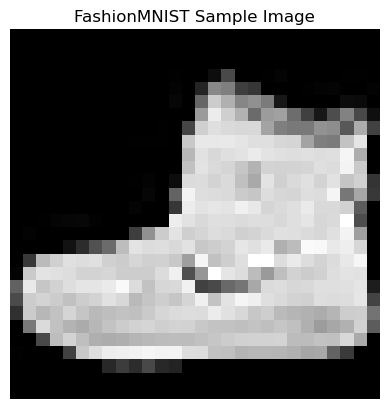

Shape of patch tokens: torch.Size([1, 49, 16])


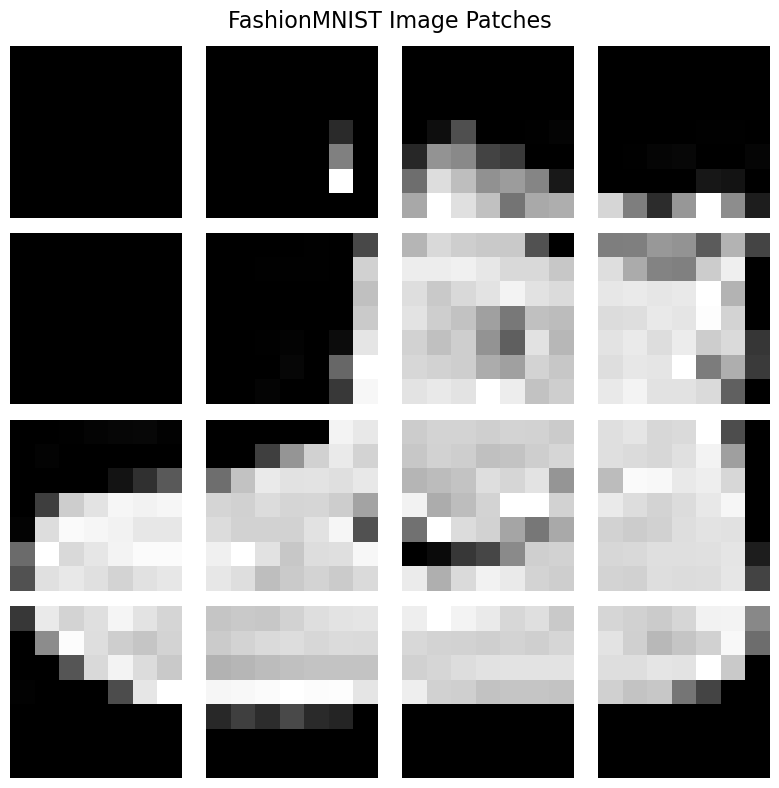

In [12]:
# %% [code]
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import numpy as np

# Download and load the FashionMNIST dataset (if not already downloaded)
transform = transforms.ToTensor()
dataset_fashion = FashionMNIST(root='./data', download=True, transform=transform)

# Get a sample image and label from the dataset
img, label = dataset_fashion[0]  # img shape: [1, 28, 28]

# Plot the FashionMNIST image
plt.imshow(img.squeeze(0), cmap='gray')
plt.title("FashionMNIST Sample Image")
plt.axis("off")
plt.show()

# Define patch size (e.g., 7x7 patches for a 28x28 image -> 4x4 grid = 16 patches)
patch_size = 7

# Add batch dimension: image shape becomes [1, 1, 28, 28]
img_batch = img.unsqueeze(0)

# Create nn.Unfold to extract patches from the image.
# This will extract non-overlapping patches of size patch_size x patch_size.
unfold = nn.Unfold(kernel_size=(patch_size, patch_size), stride=patch_size)
patches = unfold(img_batch)  # Expected shape: [1, patch_dim, num_patches]

# Print the shape of the patches tensor
# For a grayscale image: patch_dim = 1*7*7 = 49, and num_patches = (28/7)^2 = 16.
print("Shape of patch tokens:", patches.shape)

# Reshape patches to have shape [num_patches, patch_dim]
patches = patches.squeeze(0).transpose(0, 1)  # Now shape: [16, 49]

# Convert each patch back to a 2D image (7x7) for visualization
num_patches = patches.shape[0]
patches_np = patches.numpy().reshape(num_patches, patch_size, patch_size)

# Create a grid visualization (4x4 grid)
grid_size = int(np.sqrt(num_patches))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(8, 8))
fig.suptitle("FashionMNIST Image Patches", fontsize=16)
for i in range(grid_size):
    for j in range(grid_size):
        patch = patches_np[i * grid_size + j]
        axs[i, j].imshow(patch, cmap='gray')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


## Transformer Based Tokenizers

#### Initialize and Compare Two Tokenizers

In [13]:
# Sample text to demonstrate tokenization differences
sample_text = "Lowering the word low"

In [14]:
# Initialize tokenizers

# For BPE, use our custom tokenizer.
bpe_encoding = tokenizer_bpe.encode(clean_train_text)




tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2")
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")



tokens_gpt2 = tokenizer_gpt2.tokenize(sample_text)
tokens_bert = tokenizer_bert.tokenize(sample_text)

print("GPT-2 tokens:", tokens_gpt2)
print("BERT tokens:", tokens_bert)


GPT-2 tokens: ['Lower', 'ing', 'Ġthe', 'Ġword', 'Ġlow']
BERT tokens: ['lowering', 'the', 'word', 'low']


You’ll notice that GPT‑2’s tokenizer (being byte‑level) produces tokens that may include punctuation attached to words, while BERT’s WordPiece tokenizer tends to split words into subtokens (often with a "##" prefix for word pieces).

In [15]:
def visualize_tokenization(sample_text, tokenizers_dict):
    """
    Visualize tokenization for different tokenizers.
    
    Parameters:
      sample_text (str): The text to tokenize.
      tokenizers_dict (dict): A dictionary where keys are technique names (str)
                              and values are tokenizer objects.
                              
    For transformer-based tokenizers, it uses:
      - tokenizer.tokenize(sample_text)
      - tokenizer.convert_tokens_to_ids(tokens)
    
    For a custom BPE tokenizer from the Hugging Face tokenizers library, it uses:
      - tokenizer.encode(sample_text) to get both tokens and token IDs.
    """
    results = []
    for name, tokenizer in tokenizers_dict.items():
        # Check if the tokenizer has the attribute "pre_tokenizer"
        # (a heuristic to detect our custom BPE tokenizer)
        if hasattr(tokenizer, "pre_tokenizer"):
            encoding = tokenizer.encode(sample_text)
            tokens = encoding.tokens
            token_ids = encoding.ids
        else:
            tokens = tokenizer.tokenize(sample_text)
            token_ids = tokenizer.convert_tokens_to_ids(tokens)
        results.append((name, tokens, token_ids))
    
    # Try to use the tabulate library for nice formatting.
    try:
        from tabulate import tabulate
        print(tabulate(results, headers=["Technique", "Tokens", "Token IDs"], tablefmt="github"))
    except ImportError:
        # Fallback if tabulate isn't installed.
        for name, tokens, token_ids in results:
            print(f"Technique: {name}")
            print("Tokens    :", tokens)
            print("Token IDs :", token_ids)
            print("-" * 40)


tokenizers_dict = {
    "GPT-2": tokenizer_gpt2,
    "BERT": tokenizer_bert,
    "BPE": tokenizer_bpe,
}

visualize_tokenization(sample_text, tokenizers_dict)


| Technique   | Tokens                                                                                     | Token IDs                                                                |
|-------------|--------------------------------------------------------------------------------------------|--------------------------------------------------------------------------|
| GPT-2       | ['Lower', 'ing', 'Ġthe', 'Ġword', 'Ġlow']                                                  | [31426, 278, 262, 1573, 1877]                                            |
| BERT        | ['lowering', 'the', 'word', 'low']                                                         | [13845, 1996, 2773, 2659]                                                |
| BPE         | ['L', 'o', 'w', 'e', 'r', 'i', 'n', 'g', 't', 'h', 'e', 'w', 'o', 'r', 'd', 'l', 'o', 'w'] | [36, 67, 75, 57, 70, 61, 66, 59, 72, 60, 57, 75, 67, 70, 56, 64, 67, 75] |


In [16]:
def visualize_input_id_mapping(sample_text, tokenizers_dict):
    """
    Visualize the mapping between tokens and input IDs for transformer-based tokenizers.
    
    Parameters:
      sample_text (str): The text to tokenize.
      tokenizers_dict (dict): A dictionary where keys are technique names (e.g., "GPT-2", "BERT")
                              and values are tokenizer objects.
    """
    try:
        from tabulate import tabulate
        use_tabulate = True
    except ImportError:
        use_tabulate = False
    
    for name, tokenizer in tokenizers_dict.items():
        tokens = tokenizer.tokenize(sample_text)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        table = list(zip(tokens, token_ids))
        print(f"\nMapping for {name}:\n")
        if use_tabulate:
            print(tabulate(table, headers=["Token", "Input ID"], tablefmt="github"))
        else:
            for token, tid in table:
                print(f"{token} : {tid}")
        print("\n" + "="*40 + "\n")


tokenizers_dict = {
    "GPT-2": tokenizer_gpt2,
    "BERT": tokenizer_bert,
}
visualize_input_id_mapping(sample_text, tokenizers_dict)



Mapping for GPT-2:

| Token   |   Input ID |
|---------|------------|
| Lower   |      31426 |
| ing     |        278 |
| Ġthe    |        262 |
| Ġword   |       1573 |
| Ġlow    |       1877 |



Mapping for BERT:

| Token    |   Input ID |
|----------|------------|
| lowering |      13845 |
| the      |       1996 |
| word     |       2773 |
| low      |       2659 |




| **Tokenization Method** | **Methodology**                                                                                                                                              | **Advantages**                                                                                                                                                              | **Use Cases**                                                                              |
|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| **BPE**               | Starts at the character level and iteratively merges the most frequent adjacent pairs into subword tokens.                                                    | Mitigates out-of-vocabulary issues by breaking rare words into known subword units; reduces vocabulary size while preserving meaningful segments.                         | General language modeling; handling rare words; flexible between character-level and word-level representations. |
| **GPT-2**             | Uses byte-level BPE: converts text into bytes then applies BPE, preserving punctuation, casing, and fine details.                                             | Robust handling of diverse characters and noise; preserves detailed information; consistent mapping even for uncommon symbols.                                             | Generative tasks and text synthesis where fine-grained token details are essential.         |
| **BERT**              | Employs WordPiece tokenization: splits words into subwords with a "##" prefix for continuation tokens.                                                         | Effectively decomposes unknown words into known subword components; maintains contextual integrity; well-suited for capturing semantic nuances in context-rich tasks.  | Fine-tuning for classification, named entity recognition (NER), and other contextual NLP tasks.       |


## Build the Model Pipeline
We tokenize the entire training text (without adding extra special tokens) and then create a dataset class that returns fixed‑length chunks for language modeling.

In [17]:
# Tokenize full training text
encodings_gpt2 = tokenizer_gpt2(train_text, return_tensors="pt", add_special_tokens=False)
encodings_bert = tokenizer_bert(train_text, return_tensors="pt", add_special_tokens=False)
encodings_bpe = {"input_ids": torch.tensor(bpe_encoding.ids)}

Token indices sequence length is longer than the specified maximum sequence length for this model (12874 > 1024). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (11981 > 512). Running this sequence through the model will result in indexing errors


### Define a dataset class that slices the long token sequence into blocks of a fixed size:

In [18]:
class LMTokenDataset(Dataset):
    def __init__(self, encodings, block_size=4):
        # Squeeze to remove batch dimension (we provided one long string)
        self.input_ids = encodings["input_ids"].squeeze()  # Shape: [total_tokens]
        self.block_size = block_size

    def __len__(self):
        # Total number of training examples is the total token length minus the block size
        return self.input_ids.size(0) - self.block_size

    def __getitem__(self, idx):
        # x is a sequence of tokens, y is the same sequence shifted one position to the left
        x = self.input_ids[idx : idx + self.block_size]
        y = self.input_ids[idx + 1 : idx + self.block_size + 1]
        return x, y


In [19]:
block_size = 4

# GPT-2 tokenized dataset and loader
dataset_gpt2 = LMTokenDataset(encodings_gpt2, block_size)
dataloader_gpt2 = DataLoader(dataset_gpt2, batch_size=4, shuffle=True)

# BERT tokenized dataset and loader
dataset_bert = LMTokenDataset(encodings_bert, block_size)
dataloader_bert = DataLoader(dataset_bert, batch_size=4, shuffle=True)

dataset_bpe = LMTokenDataset(encodings_bpe, block_size)
dataloader_bpe = DataLoader(dataset_bpe, batch_size=4, shuffle=True)



### Define a Simple LSTM Language Model

In [20]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # x: [batch_size, seq_len]
        x_embed = self.embed(x)
        out, hidden = self.lstm(x_embed, hidden)
        logits = self.fc_out(out)  # [batch_size, seq_len, vocab_size]
        return logits, hidden


Initialize separate models using each tokenizer’s vocabulary size:

In [21]:
vocab_size_gpt2 = tokenizer_gpt2.vocab_size
vocab_size_bert = tokenizer_bert.vocab_size
vocab_size_bpe = len(tokenizer_bpe.get_vocab())

model_gpt2 = LSTMLanguageModel(vocab_size_gpt2)
model_bert = LSTMLanguageModel(vocab_size_bert)
model_bpe = LSTMLanguageModel(vocab_size_bpe)

# Define a common loss and optimizer (for demonstration, we show one forward pass)
criterion = nn.CrossEntropyLoss()
optimizer_gpt2 = optim.Adam(model_gpt2.parameters(), lr=1e-3)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=1e-3)


### Feeding Tokenized Data into the LSTM

In [22]:
# For GPT-2 tokenized data
batch_gpt2 = next(iter(dataloader_gpt2))
x_gpt2, y_gpt2 = batch_gpt2
logits_gpt2, _ = model_gpt2(x_gpt2)
print("GPT-2 model logits shape:", logits_gpt2.shape)
# Expected shape: [batch_size, block_size, vocab_size_gpt2]

# For BERT tokenized data
batch_bert = next(iter(dataloader_bert))
x_bert, y_bert = batch_bert
logits_bert, _ = model_bert(x_bert)
print("BERT model logits shape:", logits_bert.shape)
# Expected shape: [batch_size, block_size, vocab_size_bert]


GPT-2 model logits shape: torch.Size([4, 4, 50257])
BERT model logits shape: torch.Size([4, 4, 30522])


This shows that regardless of which tokenizer is used, the resulting integer token IDs can be passed directly into an LSTM model for next‑token prediction. You could proceed to train the models using a loop (with proper handling like gradient clipping, multiple epochs, and validation) and later experiment with text generation.

In [23]:
# Define device: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print("Using device:", device)

# Move models to the device
model_gpt2 = model_gpt2.to(device)
model_bert = model_bert.to(device)
model_bpe = model_bpe.to(device)

# Training hyperparameters
num_epochs = 3
criterion = nn.CrossEntropyLoss()


## ----- Train BPE Tokenized Model -----
optimizer_bpe = optim.Adam(model_bpe.parameters(), lr=1e-3)
print("\nTraining BPE Tokenized Model")
model_bpe.train()
for epoch in range(1, num_epochs + 1):
    total_loss_bpe = 0.0
    for x, y in tqdm(dataloader_bpe):
        x, y = x.to(device), y.to(device)
        optimizer_bpe.zero_grad()
        logits, _ = model_bpe(x)
        loss = criterion(logits.view(-1, vocab_size_bpe), y.view(-1))
        loss.backward()
        optimizer_bpe.step()
        total_loss_bpe += loss.item()
    avg_loss_bpe = total_loss_bpe / len(dataloader_bpe)
    print(f"BPE Epoch {epoch}/{num_epochs} | Average Loss: {avg_loss_bpe:.4f}")

# # ----- Train GPT-2 Tokenized Model -----
print("Training GPT-2 Tokenized Model")
model_gpt2.train()
for epoch in range(1, num_epochs + 1):
    total_loss_gpt2 = 0.0
    for x, y in tqdm(dataloader_gpt2):
        # Move batch data to GPU
        x = x.to(device)
        y = y.to(device)
        
        optimizer_gpt2.zero_grad()            # Clear gradients
        logits, _ = model_gpt2(x)              # Forward pass: obtain logits
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size_gpt2), y.view(-1))
        loss.backward()                        # Backpropagation
        optimizer_gpt2.step()                   # Update weights
        total_loss_gpt2 += loss.item()
    avg_loss_gpt2 = total_loss_gpt2 / len(dataloader_gpt2)
    print(f"GPT-2 Epoch {epoch}/{num_epochs} | Average Loss: {avg_loss_gpt2:.4f}")

# ----- Train BERT Tokenized Model -----
print("\nTraining BERT Tokenized Model")
model_bert.train()
for epoch in range(1, num_epochs + 1):
    total_loss_bert = 0.0
    for x, y in tqdm(dataloader_bert):
        # Move batch data to GPU
        x = x.to(device)
        y = y.to(device)
        
        optimizer_bert.zero_grad()            # Clear gradients
        logits, _ = model_bert(x)              # Forward pass: obtain logits
        # Reshape logits and targets for loss computation
        loss = criterion(logits.view(-1, vocab_size_bert), y.view(-1))
        loss.backward()                        # Backpropagation
        optimizer_bert.step()                   # Update weights
        total_loss_bert += loss.item()
    avg_loss_bert = total_loss_bert / len(dataloader_bert)
    print(f"BERT Epoch {epoch}/{num_epochs} | Average Loss: {avg_loss_bert:.4f}")

Using device: mps

Training BPE Tokenized Model


100%|██████████| 11769/11769 [04:59<00:00, 39.34it/s]


BPE Epoch 1/3 | Average Loss: 2.3891


100%|██████████| 11769/11769 [04:50<00:00, 40.52it/s]


BPE Epoch 2/3 | Average Loss: 2.1504


100%|██████████| 11769/11769 [04:44<00:00, 41.41it/s]


BPE Epoch 3/3 | Average Loss: 2.0625
Training GPT-2 Tokenized Model


100%|██████████| 3218/3218 [08:12<00:00,  6.53it/s]


GPT-2 Epoch 1/3 | Average Loss: 5.3371


100%|██████████| 3218/3218 [11:05<00:00,  4.84it/s]


GPT-2 Epoch 2/3 | Average Loss: 2.4892


100%|██████████| 3218/3218 [12:16<00:00,  4.37it/s]


GPT-2 Epoch 3/3 | Average Loss: 1.5302

Training BERT Tokenized Model


100%|██████████| 2995/2995 [07:25<00:00,  6.72it/s]


BERT Epoch 1/3 | Average Loss: 5.4804


100%|██████████| 2995/2995 [51:48<00:00,  1.04s/it]    


BERT Epoch 2/3 | Average Loss: 2.6919


100%|██████████| 2995/2995 [08:00<00:00,  6.24it/s]


BERT Epoch 3/3 | Average Loss: 1.6167


In [24]:

def generate_text(model, tokenizer, prompt, max_tokens=20):
    model.eval()
    # Attempt to encode using transformers style; if it fails, use the tokenizers library approach.
    try:
        tokens = tokenizer.encode(prompt, return_tensors="pt")
        tokens = tokens.to(device)
    except Exception:
        encoding = tokenizer.encode(prompt)
        tokens = torch.tensor(encoding.ids).unsqueeze(0).to(device)
    
    hidden = None
    for _ in range(max_tokens):
        logits, hidden = model(tokens, hidden)
        next_token_logits = logits[0, -1, :]
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)
        
    # Decode the tokens back to text
    try:
        generated = tokenizer.decode(tokens[0])
    except Exception:
        generated = tokenizer.decode(tokens[0].tolist())
    return generated

# Define a prompt
prompt = "Did you know that"

# Generate predictions using each tokenization technique
generated_gpt2 = generate_text(model_gpt2, tokenizer_gpt2, prompt)
generated_bert = generate_text(model_bert, tokenizer_bert, prompt)
generated_bpe = generate_text(model_bpe, tokenizer_bpe, prompt)

print("Generated Text (GPT-2 Tokenization):")
print(generated_gpt2)
print("\n----------------------\n")

print("Generated Text (BERT Tokenization):")
print(generated_bert)
print("\n----------------------\n")

print("Generated Text (BPE Tokenization):")
print(generated_bpe)


Generated Text (GPT-2 Tokenization):
Did you know that any armed conflict between the civilian Watch no Hana ) , 2 clerks , more permanent quarters . The

----------------------

Generated Text (BERT Tokenization):
[CLS] did you know that [SEP]. a " summary of work " for 900 @ - @ themed work. it was costumes in 1946

----------------------

Generated Text (BPE Tokenization):
D i d y o u k n o w t h a t t l e s i n c e ) , i t o r , i s o l o
